In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 2025

# Load data

In [3]:
df = pd.read_csv("../../data/bbc-text.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


# Data cleaning

In [4]:
df.isnull().mean() # nulls
(df["text"].str.strip()=="").sum() # empty

category    0.0
text        0.0
dtype: float64

np.int64(0)

In [5]:
# there are 99 duplicates
df.duplicated().sum() # check duplicate category and text
df.duplicated('text').sum() # check if text is duplicated under different categories

np.int64(99)

np.int64(99)

In [6]:
df = df.drop_duplicates()
df.shape

(2126, 2)

# Split data

Split data prior to EDA to avoid any 'snooping' at the test set.

In [7]:
X = df.text
y = df.category

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.30,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    stratify=y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE
)

train_df = pd.DataFrame({'text': X_train, 'category': y_train})
val_df   = pd.DataFrame({'text': X_val, 'category': y_val})
test_df  = pd.DataFrame({'text': X_test, 'category': y_test})

# Basic EDA

In [13]:
# check the stratification worked in the split:
train_df.category.value_counts(normalize=True).round(3)
val_df.category.value_counts(normalize=True).round(3)
test_df.category.value_counts(normalize=True).round(3)

category
business         0.229
sport            0.229
politics         0.188
tech             0.180
entertainment    0.173
Name: proportion, dtype: float64

category
sport            0.231
business         0.228
politics         0.189
tech             0.180
entertainment    0.174
Name: proportion, dtype: float64

category
business         0.231
sport            0.231
politics         0.186
tech             0.180
entertainment    0.174
Name: proportion, dtype: float64

In [119]:
train_df['word_count'] = train_df['text'].str.split().str.len()
train_df['char_count'] = train_df['text'].str.len()
train_df['sentence_count'] = train_df['text'].str.count(r'[.!?]+')

In [120]:
train_df[['word_count', 'char_count', 'sentence_count']].describe().round(3)

,word_count,char_count,sentence_count
count,1557.000,1557.000,1557.000
mean,390.344,2262.598,19.543
std,255.229,1436.956,13.244
min,90.000,501.000,4.000
25%,246.000,1436.000,13.000
50%,332.000,1932.000,17.000
75%,479.000,2799.000,23.000
max,4492.000,25483.000,246.000


In [8]:
# 36,962 unique words in the data
unique_words = set()
for text in train_df.text:
    unique_words.update(text.split())
len(unique_words)

36560

In [9]:
# cumsum = word_counts.value_counts(normalize=True).sort_index().cumsum()
# cumsum.plot()

In [26]:
# pd.DataFrame(vec.fit_transform(train_df.text).toarray()).nunique().sort_values(ascending=False) # document counts

<Axes: ylabel='Proportion'>

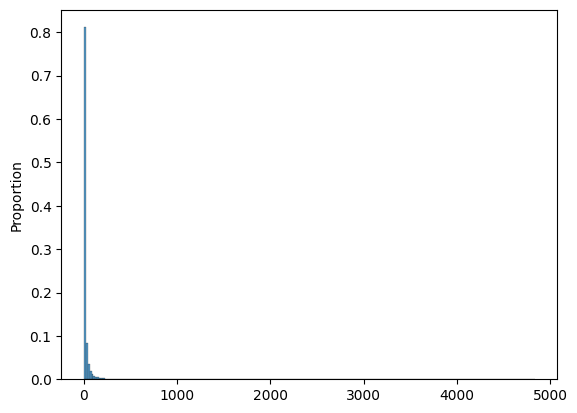

<Axes: ylabel='Proportion'>

(0.0, 100.0)

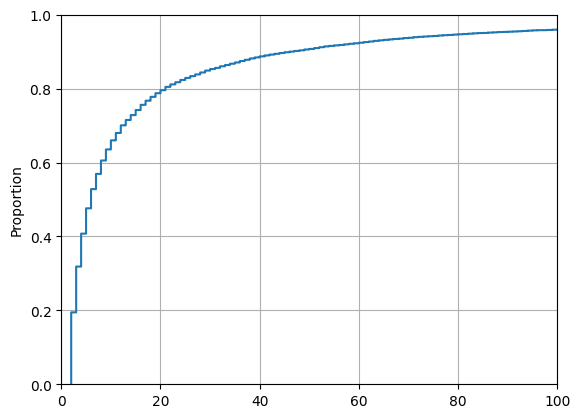

In [35]:
vec = CountVectorizer(
    stop_words='english',
    # max_features=20000,
    min_df=2,           # Ignore words appearing in <2 documents
    max_df=0.95,        # Ignore words appearing in >95% of documents
    lowercase=True,     # Normalize case
    token_pattern=r'\b[a-zA-Z]{2,}\b'  # Only alphabetic words, 2+ chars
);
word_counts = pd.Series(
    vec.fit_transform(train_df.text)
    .toarray()
    .sum(axis=0)
)
sns.histplot(word_counts, stat='proportion')
# plt.xlim(0,100)
plt.show()

sns.ecdfplot(word_counts)
plt.xlim(0,100)
plt.grid()

# EDA by category

In [117]:
# politics and tech has notably more words per article on average
(
    train_df.groupby('category')[['word_count', 'char_count', 'sentence_count']]
    .mean()
    .sort_values('word_count')
    .round(3)
)

,word_count,char_count,sentence_count
category,,,
business,327.574,1944.487,18.126
sport,335.927,1893.689,17.120
entertainment,344.781,1963.619,17.274
politics,454.599,2645.863,20.880
tech,516.231,3024.438,25.214


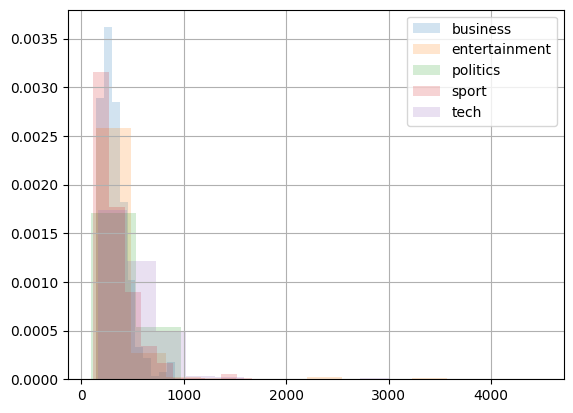

In [48]:
train_df.groupby('category').word_count.hist(alpha=0.2, legend=True, density=True);

<Axes: ylabel='word'>

Text(0.5, 1.0, 'tech')

<Axes: ylabel='word'>

Text(0.5, 1.0, 'business')

<Axes: ylabel='word'>

Text(0.5, 1.0, 'sport')

<Axes: ylabel='word'>

Text(0.5, 1.0, 'entertainment')

<Axes: ylabel='word'>

Text(0.5, 1.0, 'politics')

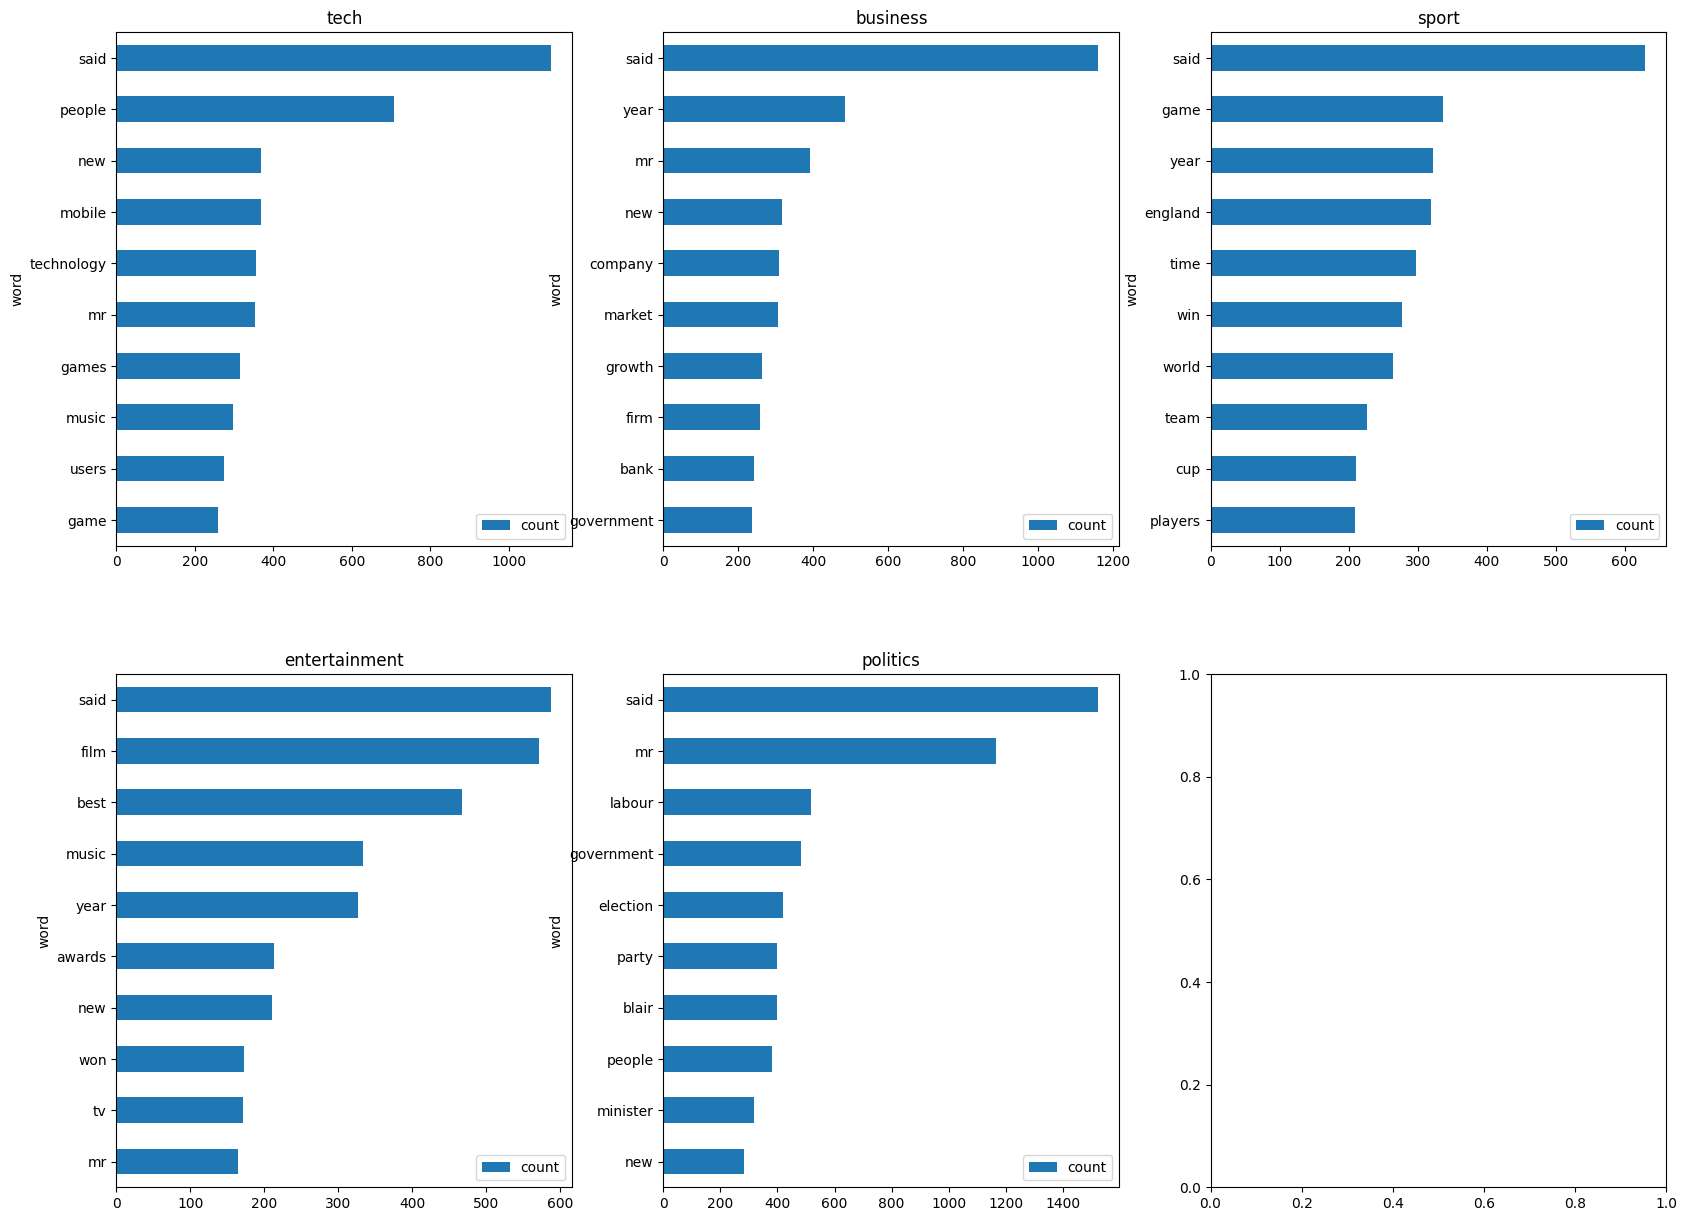

In [113]:
# there appear to be strong differences in top words per category so the classes may be reasonable separable for even a simple model with TFIDF features

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,15))
plt.subplots_adjust(hspace=0.25)

top_words_cat = {}
for i, cat in enumerate(df.category.unique()):
    vec = CountVectorizer(stop_words='english', max_features=10);
    word_counts = vec.fit_transform(train_df.loc[train_df.category==cat, 'text']);
    word_counts_tot = word_counts.toarray().sum(axis=0)
    top_words = vec.get_feature_names_out()
    row, col = np.divmod(i, 3)
    (
        pd.DataFrame({'word': top_words, 'count': word_counts_tot})
        .set_index('word')
        .sort_values('count')
        .plot(kind='barh', ax=ax[row, col])
    )
    ax[row, col].set_title(cat)